In [ ]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 660 kB 4.7 MB/s 


Point Cloud Classification with PointNet

> Indented block




In [ ]:
# Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


Download the Dataset


In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 5s 0us/step


Visualize a Mesh from the Dataset


In [ ]:
mesh =  trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0232.off"))
mesh.show()

# Échantillonner un maillage et afficher le résultat


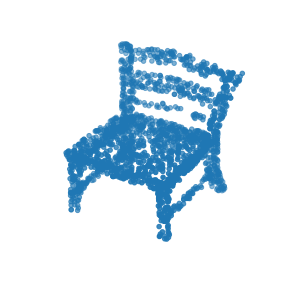

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

La Fonction parse_dataset
:
Chaque maillage est chargé et échantillonné dans un nuage de points et est renvoyé sous forme de tableau numpy

In [ ]:
def parse_dataset(num_points=2048):

    train_pc = []
    train_labels = []
    test_pc = []
    test_labels = []
    class_ids = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_ids[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_pc.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_pc.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_pc),
        np.array(test_pc),
        np.array(train_labels),
        np.array(test_labels),
        class_ids,
    )

## Une Fonction pour afficher et sauvegarder des tracés au format png pendant l'apprentissage

In [ ]:
import matplotlib
# Specifying the backend to be used before importing pyplot
# to avoid "RuntimeError: Invalid DISPLAY variable"
matplotlib.use('agg')
import matplotlib.pyplot as plt
import keras
import numpy as np

class TrainingPlot(keras.callbacks.Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:

            N = np.arange(0, len(self.losses))

            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            #plt.style.use("seaborn")

            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            # Make sure there exists a folder called output in the current directory
            # or replace 'output' with whatever direcory you want to put in the plots
            plt.savefig('drive/MyDrive/PFE_POINTNET/epochs_Plots/Epoch-{}.png'.format(epoch))
            plt.close()

Analyser l'ensemble de données et traiter chaque classe


In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_pc, test_pc, train_labels, test_labels, class_ids = parse_dataset(NUM_POINTS)

processing class: table
processing class: night_stand
processing class: dresser
processing class: bathtub
processing class: desk
processing class: toilet
processing class: chair
processing class: monitor
processing class: sofa
processing class: bed


### Enregistrement des nuages de points sous des fichiers pickle  

In [ ]:
import pickle

# once loaded save the numpy arrays to pickle files to use later
!cd drive/MyDrive/PFE_POINTNET
pickle.dump(train_pc, open("trainpc.pkl", "wb"))
pickle.dump(test_pc, open("testpc.pkl", "wb"))
pickle.dump(train_labels, open("trainlabels.pkl", "wb"))
pickle.dump(test_labels, open("testlabels.pkl", "wb"))
pickle.dump(class_ids, open("class_ids.pkl", "wb"))


/bin/bash: line 0: cd: drive/MyDrive/PFE_POINTNET: No such file or directory


In [ ]:
!mv testlabels.pkl drive/MyDrive/PFE_POINTNET
!mv testpc.pkl drive/MyDrive/PFE_POINTNET
!mv trainlabels.pkl drive/MyDrive/PFE_POINTNET
!mv trainpc.pkl drive/MyDrive/PFE_POINTNET
!mv class_ids.pkl drive/MyDrive/PFE_POINTNET

mv: cannot move 'testlabels.pkl' to 'drive/MyDrive/PFE_POINTNET': No such file or directory
mv: cannot move 'testpc.pkl' to 'drive/MyDrive/PFE_POINTNET': No such file or directory
mv: cannot move 'trainlabels.pkl' to 'drive/MyDrive/PFE_POINTNET': No such file or directory
mv: cannot move 'trainpc.pkl' to 'drive/MyDrive/PFE_POINTNET': No such file or directory
mv: cannot move 'class_ids.pkl' to 'drive/MyDrive/PFE_POINTNET': No such file or directory


# CAN START HERE IF POINT CLOUD IS ALREADY PROCESSED AND SAVED AS PICKLE FILES

In [ ]:
# load the data from pickle files if already present
import pickle 
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32
train_pc = []
train_labels = []
test_pc = []
test_labels = []
class_ids = {}
def load_from_files():
  train_pc = pickle.load(open("trainpc.pkl", "rb"))
  train_labels = pickle.load(open("trainlabels.pkl", "rb"))
  test_pc = pickle.load(open("testpc.pkl", "rb"))
  test_labels = pickle.load(open("testlabels.pkl", "rb"))
  class_ids = pickle.load(open("class_ids.pkl", "rb"))

## Augmenter les nuages ​​de points groupés par rotation et tremblement


In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_pc, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_pc, test_labels))

train_dataset = train_dataset.shuffle(len(train_pc)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_pc)).batch(BATCH_SIZE)

Functions to Build the Model


In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

Function to create T-net Layers


In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

Create the Convolutional Neural Network


In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

Compile and Train the Model


In [ ]:
from tensorflow import keras
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

hist = model.fit(train_dataset, epochs=35, validation_data=test_dataset)

Epoch 1/35
125/125 [==============================] - 38s 170ms/step - loss: 3.4666 - accuracy: 0.3032 - val_loss: 120945875328434176.0000 - val_accuracy: 0.2819
Epoch 2/35
125/125 [==============================] - 21s 165ms/step - loss: 3.0113 - accuracy: 0.4127 - val_loss: 19757426278400.0000 - val_accuracy: 0.4471
Epoch 3/35
125/125 [==============================] - 21s 167ms/step - loss: 2.7091 - accuracy: 0.5029 - val_loss: 7107890380800.0000 - val_accuracy: 0.4141
Epoch 4/35
125/125 [==============================] - 21s 169ms/step - loss: 2.5051 - accuracy: 0.5718 - val_loss: 1740523333356617728.0000 - val_accuracy: 0.5826
Epoch 5/35
125/125 [==============================] - 21s 169ms/step - loss: 2.3432 - accuracy: 0.6219 - val_loss: 1988523458560.0000 - val_accuracy: 0.6013
Epoch 6/35
125/125 [==============================] - 21s 168ms/step - loss: 2.1492 - accuracy: 0.6788 - val_loss: 384820224.0000 - val_accuracy: 0.4824
Epoch 7/35
125/125 [==============================

###visualize the history of the collback function of the trianing

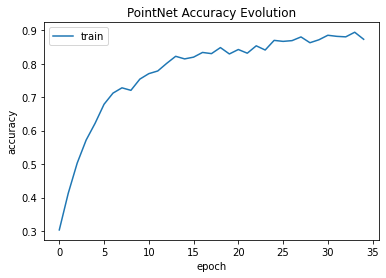

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.title('PointNet Accuracy Evolution')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

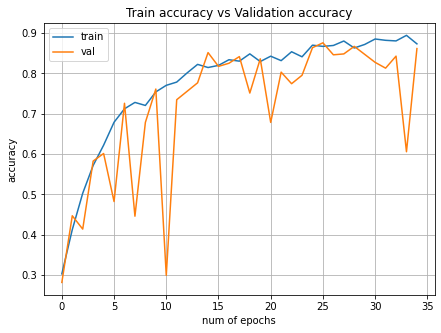

In [ ]:
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('num of epochs')
plt.ylabel('accuracy')
plt.title('Train accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['train','val'])
#print(plt.style.available) # use ggplot or classic or bmh
plt.style.use(['ggplot'] )

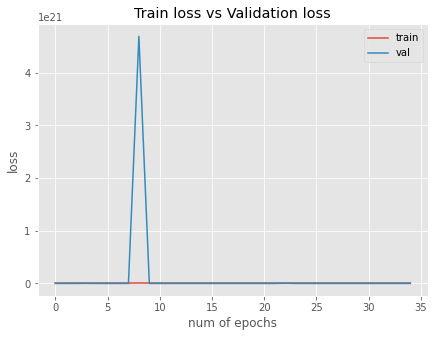

In [ ]:
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('num of epochs')
plt.ylabel('loss')
plt.title('Train loss vs Validation loss')
plt.grid(True)
plt.legend(['train','val'])
#print(plt.style.available)
plt.style.use(['ggplot'] )

##Plot train loss and accuracy + Validation Loss and Accuracy

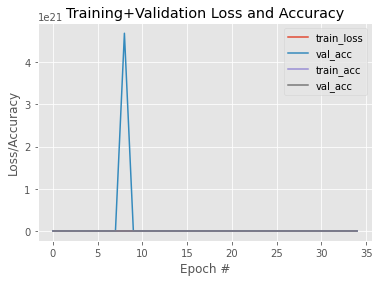

In [ ]:
plt.figure()
plt.plot( hist.history['loss'], label = "train_loss")
plt.plot( hist.history['val_loss'], label = "val_acc")
plt.plot( hist.history['accuracy'], label = "train_acc")
plt.plot( hist.history['val_accuracy'], label = "val_acc")
plt.title("Training+Validation Loss and Accuracy" )
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

##Visualize the predictions of the model

##Evaluate the model

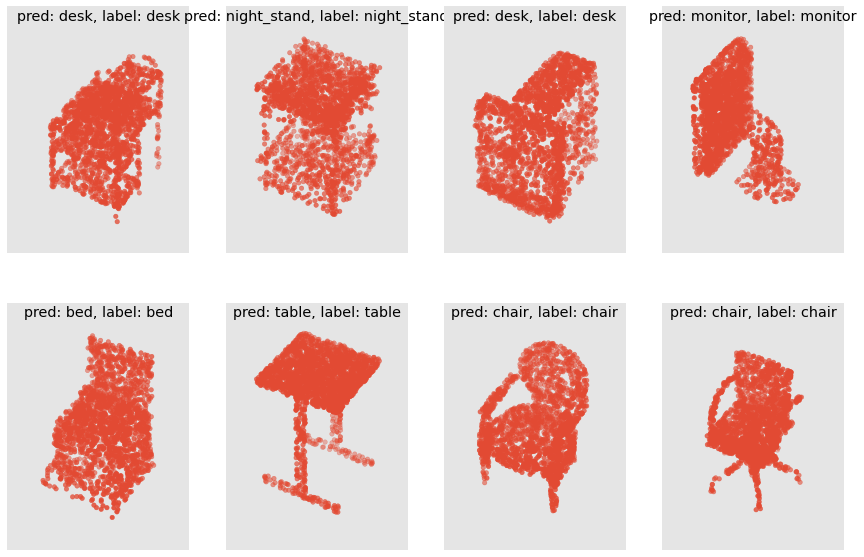

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            class_ids[preds[i].numpy()], class_ids[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
score = model.evaluate(test_dataset,verbose=0)
print('Test Score: ',score[0])
print('Test Accuracy: ',score[1])

Test Score:  160128303104.0
Test Accuracy:  0.8612334728240967
